In [12]:
import numpy as np
import pandas as pd
from bisect import bisect

from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [13]:
dir_path = 'waypoints.csv'
df = pd.read_csv(dir_path)
x = df['x'].values.tolist()
y = df['y'].values.tolist()

In [14]:
def initialise_cubic_spline(x, y, ds, bc_type):

    distance = np.concatenate((np.zeros(1), np.cumsum(np.hypot(np.ediff1d(x), np.ediff1d(y)))))
    s = np.arange(0, distance[-1], ds)
    points = np.array([x, y]).T
    cs = CubicSpline(distance, points, bc_type=bc_type, axis=0, extrapolate=False)

    return cs, s

def generate_cubic_spline_scipy(x, y, ds=0.05, bc_type='natural'):
    
    cs, s = initialise_cubic_spline(x, y, ds, bc_type)

    # dx = dcs[0],  dy = dcs[1], ddx = ddcs[0],  ddy = ddcs[1]
    dcs = cs.derivative(1)(s).T
    yaw = np.arctan2(dcs[1], dcs[0])

    ddcs = cs.derivative(2)(s).T
    curvature = (ddcs[1]*dcs[0] - ddcs[0]*dcs[1]) / ((dcs[0]*dcs[0] + dcs[1]*dcs[1])**1.5)

    cs_points = cs(s).T

    return cs_points[0], cs_points[1], yaw, curvature

In [15]:
class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = len(x)
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = self.a[i] + self.b[i]*delta_x + self.c[i]*delta_x*delta_x + self.d[i]*delta_x*delta_x*delta_x

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*delta_x + 3.0*self.d[i]*delta_x*delta_x

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            delta_x = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * delta_x

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        delta_x = np.diff(x)
        delta_y = np.diff(y)
        self.ds = np.hypot(delta_x, delta_y)

        s = [0]
        s.extend(np.cumsum(self.ds))

        return s

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx*dx + dy*dy)**1.5)

        return k

def generate_cubic_path(x, y, ds=0.05):

    if len(x) != len(y):
        print("Length of x and y must be equal")
        exit()

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

In [16]:
ds = 0.1
scipy_t = %timeit -o generate_cubic_spline_scipy(x, y, ds)
python_t = %timeit -o generate_cubic_path(x, y, ds)

787 µs ± 7.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
66.2 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
print(f"Scipy test: \n{scipy_t}")
print(f"Python test: \n{python_t}")

Scipy test: 
787 µs ± 7.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Python test: 
66.2 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%lprun -f generate_cubic_spline_scipy generate_cubic_spline_scipy(x, y, ds)

Timer unit: 1e-06 s

Total time: 0.001572 s
File: <ipython-input-14-8a8a7c22bec4>
Function: generate_cubic_spline_scipy at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def generate_cubic_spline_scipy(x, y, ds=0.05, bc_type='natural'):
    11                                               
    12         1        779.0    779.0     49.6      cs, s = initialise_cubic_spline(x, y, ds, bc_type)
    13                                           
    14                                               # dx = dcs[0],  dy = dcs[1], ddx = ddcs[0],  ddy = ddcs[1]
    15         1        150.0    150.0      9.5      dcs = cs.derivative(1)(s).T
    16         1        228.0    228.0     14.5      yaw = np.arctan2(dcs[1], dcs[0])
    17                                           
    18         1        130.0    130.0      8.3      ddcs = cs.derivative(2)(s).T
    19         1        164.0    164.0     10.4      curvature = (ddcs

In [19]:
%lprun -f generate_cubic_path generate_cubic_path(x, y, ds)

Timer unit: 1e-06 s

Total time: 0.18848 s
File: <ipython-input-15-dcf38cb0b471>
Function: generate_cubic_path at line 148

Line #      Hits         Time  Per Hit   % Time  Line Contents
   148                                           def generate_cubic_path(x, y, ds=0.05):
   149                                           
   150         1          2.0      2.0      0.0      if len(x) != len(y):
   151                                                   print("Length of x and y must be equal")
   152                                                   exit()
   153                                           
   154         1       1410.0   1410.0      0.7      sp2d = Spline2D(x, y)
   155         1         13.0     13.0      0.0      s = np.arange(0, sp2d.s[-1], ds)
   156                                           
   157         1          1.0      1.0      0.0      px = []
   158         1          1.0      1.0      0.0      py = []
   159         1          0.0      0.0      0.0      py

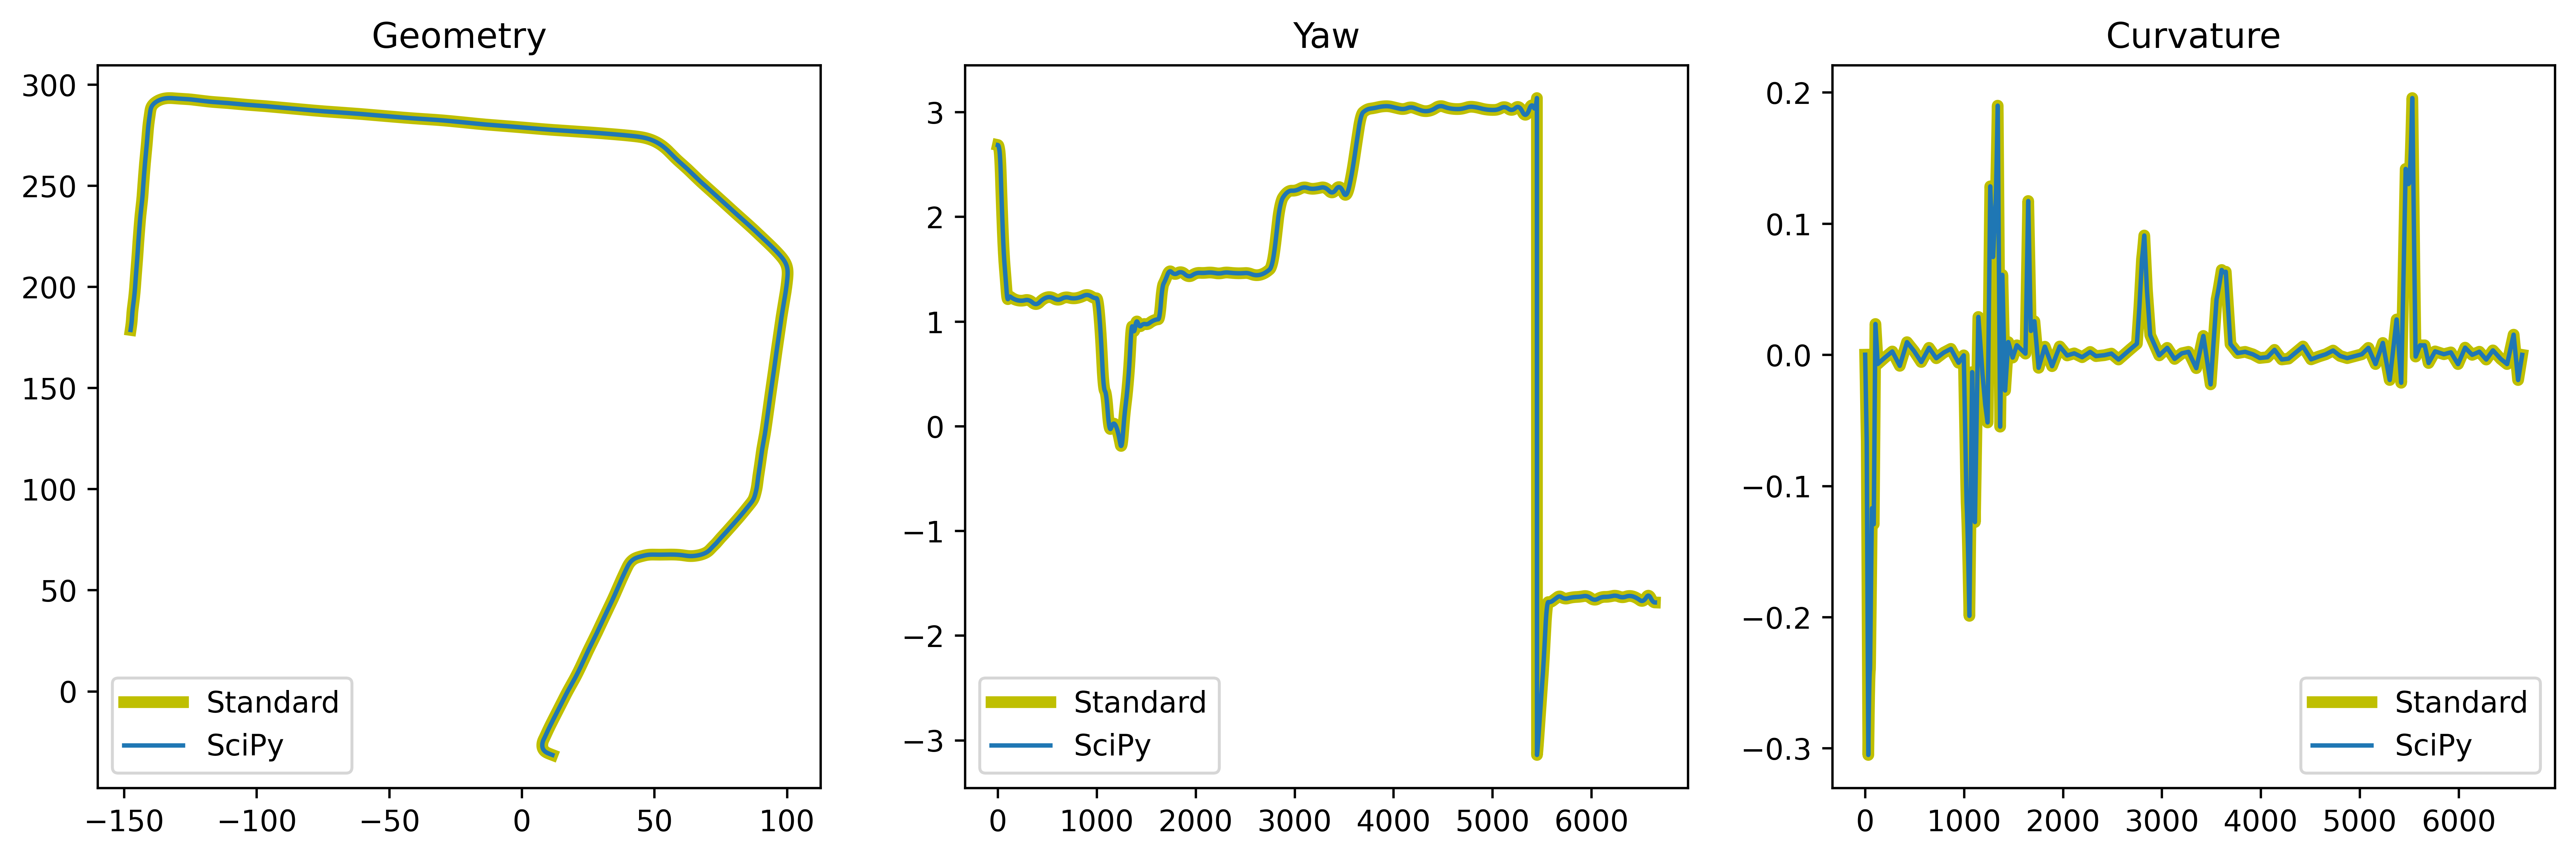

In [37]:
%matplotlib inline

sx, sy, syaw, sk = generate_cubic_spline_scipy(x, y, ds)
px, py, pyaw, pk = generate_cubic_path(x, y, ds)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_box_aspect(1)
ax[0].set_title('Geometry')
ax[0].plot(px, py, color='y', linewidth=4, label='Standard')
ax[0].plot(sx, sy, label='SciPy')
ax[0].legend()

ax[1].set_box_aspect(1)
ax[1].set_title('Yaw')
ax[1].plot(pyaw, color='y', linewidth=4, label='Standard')
ax[1].plot(syaw, label='SciPy')
ax[1].legend()

ax[2].set_box_aspect(1)
ax[2].set_title('Curvature')
ax[2].plot(pk, color='y', linewidth=4, label='Standard')
ax[2].plot(sk, label='SciPy')
ax[2].legend()

plt.show()

In [34]:
calculate_1d_cosine_similarity = lambda a, b : np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))

k_sim = calculate_1d_cosine_similarity(pk, sk) * 100
yaw_sim = calculate_1d_cosine_similarity(pyaw, syaw) * 100
print(f"Curvature similarity: {np.round(k_sim, 5)}%")
print(f"Yaw similarity: {np.round(yaw_sim, 5)}%")

Curvature similarity: 100.0%
Yaw similarity: 100.0%
